# 6. The N-Body Problem

## Solving the true "2-body" problem

We've learned how to compute the motion of a _single_ body on which something else exerts a force. That "something else" may have been a spring, the friction of the air, or the Earth itself. But so far we've ignored what happens to that "something else", how is it affected by the force it exerts on our body of interest. We've cheated a bit -- time to make it right.

Generally, this is what **Newton's third law** helps us solve:

> ***A body exerting force on another experiences a force of equal magnitude and and in the opposite direction.***

Let's look at this in the context of gravity. Consider two bodies: the Earth and the Moon. Experimentally, we know that the Earth exerts a force on the Moon that is equal to:

$$ \vec{F}_{\rm E-M} = - G \frac{M_E M_M}{r_{\rm E-M}^2} \hat{r}_{\rm E-M} $$

where $M_E$ is the mass of the Earth, $M_M$ the mass of the Moon, $\vec{r}_{\rm E-M}$ is the vector *from the center of the Earth to the Moon* (note the direction!), and $\vec{F}_{E-M}$ is the force exerted on the Moon by the Earth (note it points *towards* the Earth's center -- gravity is attractive).

What of the Earth, does it feel any forces? By Newton's third law it follows that the Earth must also experience an equal but opposite force -- i.e.:

$$ \vec{F}_{M-E} = - \vec{F}_{E-M} = G \frac{M_E M_M}{r_{\rm E-M}^2} \hat{r}_{\rm E-M} $$

and that's it.

But let's look at this another way. This equation and the one above for the Moon are nearly identical: the minus (-) sign is the totallity of the difference. By noting that $\vec{r}_{\rm E-M} = - \vec{r}_{\rm M-E}$ and a little bit of rearranging, we find we can write the above as:

$$ \vec{F}_{M-E} = - G \frac{M_E M_M}{r_{\rm M-E}^2} \hat{r}_{\rm M-E} $$

This is nothing more than the equation we'd write for the force of gravity that the _Earth_ would experience due to the Moon.

Why is this viewpoint interesting? Because in a situation with any number of bodies -- the famous $N$-body problem -- we can compute the forces acting on some body $i$ by summing up the forces, calculated using the equation above, exerted by all the remaining bodies in the system.

But first, let's fully solve the two-body problem (numerically).

## Numerically solving the two-body problem

Now we know how to compute the forces the two bodies experience. To go from forces to motions, we plug them into Newton's second law:

$$ \ddot{\vec{r}} = \frac{\vec{F}}{m} $$

For the Moon, we get the equation:

$$ 
\ddot{\vec{r}}_M = \frac{\vec{F}}{M_M} 
           = - G \frac{M_E}{\left|\vec{r_M} - \vec{r_E}\right|^2} \cdot \frac{\vec{r_M} - \vec{r_E}}{|\vec{r_M} - \vec{r_E}|} 
           = - G \frac{M_E}{\left|\vec{r_M} - \vec{r_E}\right|^3} \cdot \left(\vec{r_M} - \vec{r_E}\right)
$$

. Here, $\vec{r}_M$ is a vector pointing to the center of the Moon from some arbitrary origing of the coordinate system, and $\vec{r}_E$ is a vector pointing to the center of the Earth. The difference of thost two vectors, $\vec{r_M} - \vec{r_E}$, is then a vector pointing from the Earth to the Moon. Therefore, the denominator of the first fraction is just the distance squared from the Earth to the Moon, while the second fraction is a unit vector pointing in the Earth-Moon direction. That is how we end up in the final version of the equation with a _cube_ of the distance in the denominator -- $\vec{F} \propto - G \frac{M_E}{r^3} \vec{r}$. Note this is nothing more than a neat mathematical trick to represent the _direction_ of this force: the _strength_ of the force of gravity still falls off as the square of separation, not the cube!

Similarly, the Earth's will be affected by the force exerted upon it by the Moon. Doing the math, we find the Earth will accelerate as:

$$ 
\ddot{\vec{r}}_E = - G \frac{M_M}{\left|\vec{r_E} - \vec{r_M}\right|^3} \cdot \left(\vec{r_E} - \vec{r_M}\right)
$$

These two second-order ordinary differential equations -- one for the location of the Moon, and the other for the Earth -- hold true, at all times. As the Earth changes position, the force on the Moon changes, thus changing its acceleration, thus changing the Moon's position. Moon's changing position in turn changes the forces the Earth feels, thus imparting the acceleration to the Earth, and therefore causing it to change velocity and shift position, and so on, and so on...

We have to solve these equations, and do so *self-consistently*. How do we do it? Well, it turns out we already have all the tools we need. This situation is conceptually no different than when we previously solved problems in 2D or 3D (see Chapter 4); there we've also had a *system* of equations that all had to be true at the same time. The only difference is that -- rather than three -- we'll now have six equations to take care of.

Remember what we've done for 3D motion of a single body:

$$ \ddot x = \frac{F_x}{m} $$

$$ \ddot y = \frac{F_y}{m} $$

$$ \ddot z = \frac{F_z}{m} $$

and now do something similar for the two bodies:

$$ \ddot x_M = \frac{F_{E-M,x}}{M_M} $$

$$ \ddot y_M = \frac{F_{E-M,y}}{M_M} $$

$$ \ddot z_M = \frac{F_{E-M,z}}{M_M} $$

$$ \ddot x_E = \frac{F_{M-E,x}}{M_E} $$

$$ \ddot y_E = \frac{F_{M-E,y}}{M_E} $$

$$ \ddot z_E = \frac{F_{M-E,z}}{M_E} $$


We now have six second-order ODEs. We turn these (using our usual trick) to _twelve_ first-order ODEs, and then solve them with (say) our Euler solver. Let's first do this, and then study and understand the results:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#
# A version of the integrate function for three bodies (12 ODEs!)
#
def integrate(
              xM_dot, vxM_dot,   # Equations of motions, Moon
              yM_dot, vyM_dot,
              zM_dot, vzM_dot,
              xE_dot, vxE_dot,   # Equations of motion, Earth
              yE_dot, vyE_dot,
              zE_dot, vzE_dot,

              tbegin, tend,      # time span
              xM0, vxM0, yM0, vyM0, zM0, vzM0,  # initial conditions, Moon
              xE0, vxE0, yE0, vyE0, zE0, vzE0,  # initial conditions, Earth

              dt):
    # set up initial conditions
    t = tbegin
    xM, vxM = xM0, vxM0
    yM, vyM = yM0, vyM0
    zM, vzM = zM0, vzM0
    xE, vxE = xE0, vxE0
    yE, vyE = yE0, vyE0
    zE, vzE = zE0, vzE0

    xMval, vxMval = [], []
    yMval, vyMval = [], []
    zMval, vzMval = [], []
    xEval, vxEval = [], []
    yEval, vyEval = [], []
    zEval, vzEval = [], []

    tval = []
    while t < tend - dt/2.:  # why did I do this? Ask me about numerical (im)precision...!
        tval.append(t)

        xMval.append(xM)
        vxMval.append(vxM)
        yMval.append(yM)
        vyMval.append(vyM)
        zMval.append(zM)
        vzMval.append(vzM)
        xEval.append(xE)
        vxEval.append(vxE)
        yEval.append(yE)
        vyEval.append(vyE)
        zEval.append(zE)
        vzEval.append(vzE)

        xMnew  =  xM +  xM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        vxMnew = vxM + vxM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        yMnew  =  yM +  yM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        vyMnew = vyM + vyM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        zMnew  =  zM +  zM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        vzMnew = vzM + vzM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        xEnew  =  xE +  xE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        vxEnew = vxE + vxE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        yEnew  =  yE +  yE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        vyEnew = vyE + vyE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        zEnew  =  zE +  zE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        vzEnew = vzE + vzE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t) * dt
        
        xM, vxM = xMnew, vxMnew
        yM, vyM = yMnew, vyMnew
        zM, vzM = zMnew, vzMnew
        xE, vxE = xEnew, vxEnew
        yE, vyE = yEnew, vyEnew
        zE, vzE = zEnew, vzEnew
        t = t + dt

    returns = (tval, 
            xMval, vxMval, yMval, vyMval, zMval, vzMval,
            xEval, vxEval, yEval, vyEval, zEval, vzEval
           )
    return [np.asarray(r) for r in returns]

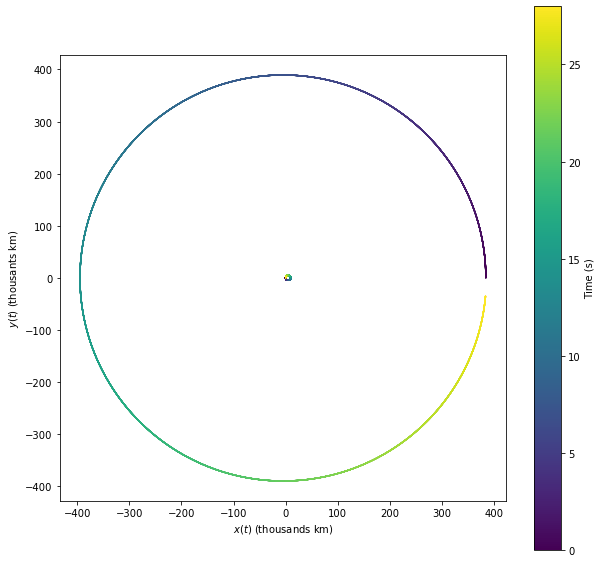

In [2]:
# Helper function: the force the Earth exerts on the Moon
def F_EarthOnMoon(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    x, y, z = xM - xE, yM - yE, zM - zE
    r = np.sqrt(x**2 + y**2 + z**2)
    f = - G*Me*Mm / r**2
    return f * x/r, f * y/r, f * z/r

# Helper function: the force the Moon exerts on the Earth
def F_MoonOnEarth(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    x, y, z = xE - xM, yE - yM, zE - zM
    r = np.sqrt(x**2 + y**2 + z**2)
    f = - G*Me*Mm / r**2
    return f * x/r, f * y/r, f * z/r

## 12 ODEs for this problem
def xM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    return vxM

def yM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    return vyM

def zM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    return vzM

def vxM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    fx, fy, fz = F_EarthOnMoon(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t)
    return fx/Mm

def vyM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    fx, fy, fz = F_EarthOnMoon(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t)
    return fy/Mm

def vzM_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    fx, fy, fz = F_EarthOnMoon(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t)
    return fz/Mm

def xE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    return vxE

def yE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    return vyE

def zE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    return vzE

def vxE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    fx, fy, fz = F_MoonOnEarth(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t)
    return fx/Me

def vyE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    fx, fy, fz = F_MoonOnEarth(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t)
    return fy/Me

def vzE_dot(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    fx, fy, fz = F_MoonOnEarth(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t)
    return fz/Me

#
# Set up the initial conditions that will lead to the Moon orbiting
# in a circular orbit in the x-y plane.
#
G = 6.67e-11 # in N kg^-2 m^2
Me = 5.972e24 # mass of the Earth
Mm = 7.34767209e22 # mass of the Moon
rMoon = 384_400_000  # Earth-Moon distance
vCircM = np.sqrt(G*(Me+Mm)/rMoon)  # Circular speed of the Moon (explanation further down)
vCircE = vCircM*Mm/Me # Circular speed of the Earth (explanation further down)

km = 1000 # meters in a kilometer
day = 60*60*24 # seconds in a day

tbegin, tend = 0, 28*day
xM0, vxM0 = rMoon, 0
yM0, vyM0 = 0, vCircM
zM0, vzM0 = 0, 0

xE0, vxE0 = 0, 0
yE0, vyE0 = 0, -vCircE
zE0, vzE0 = 0, 0

dt = 0.001*day
(
    tval, 
    xMval, vxMval, yMval, vyMval, zMval, vzMval,
    xEval, vxEval, yEval, vyEval, zEval, vzEval
) = integrate(
    xM_dot, vxM_dot,
    yM_dot, vyM_dot,
    zM_dot, vzM_dot,
    xE_dot, vxE_dot,
    yE_dot, vyE_dot,
    zE_dot, vzE_dot,
    tbegin, tend, 
    xM0, vxM0, yM0, vyM0, zM0, vzM0,
    xE0, vxE0, yE0, vyE0, zE0, vzE0,
    dt
)

# Plot the result
fig = plt.figure(figsize=(10, 10))
plt.scatter(xMval / (1000*km), yMval / (1000*km), c=tval / day, s=0.1)
plt.scatter(xEval / (1000*km), yEval / (1000*km), c=tval / day, s=0.1)
plt.gca().set_aspect('equal')
plt.xlabel("$x(t)$ (thousands km)")
plt.ylabel("$y(t)$ (thousants km)")
plt.colorbar(label="Time (s)");

And here it is! The outer circle shows the position of the Moon as a function of time (denoted by the color). As we hoped, it's showing a circular orbit with a period of roughly 28 days.

More interesting is what the Earth does. Let's Zoom into the center of the plot:

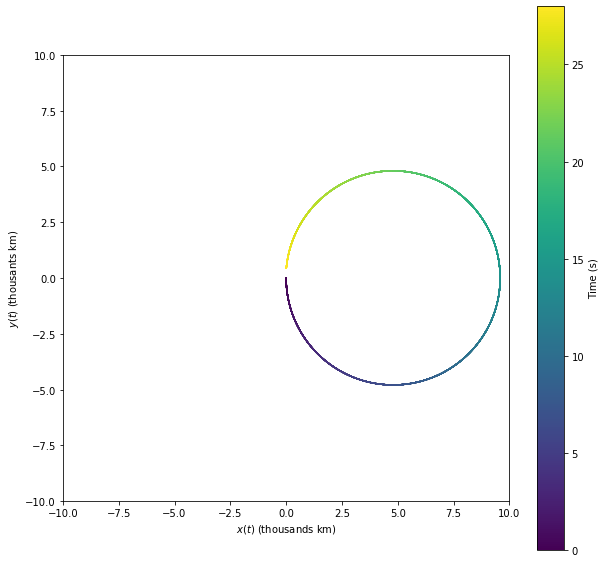

In [3]:
# Plot the result
fig = plt.figure(figsize=(10, 10))
plt.scatter(xMval / (1000*km), yMval / (1000*km), c=tval / day, s=0.1)
plt.scatter(xEval / (1000*km), yEval / (1000*km), c=tval / day, s=0.1)
plt.gca().set_aspect('equal')
plt.xlabel("$x(t)$ (thousands km)")
plt.ylabel("$y(t)$ (thousants km)")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(label="Time (s)");

What's going on here is that the Earth itself is undergoing a (smaller) circular motion, because the Moon is tugging on it!

The way we've set up the problem, the center of the Earth was at (0, 0) at $t=0$. As the Moon revolved around it and made ~half of the circle, the Earth responded by moving half the circle in the _opposite_ direction. And by the time the Moon got back to the original starting point, the Earth returned to the original starting point -- which in this coordinate system is $(0, 0)$.

A closer inspection (and a little bit of math) would reveal that both the Earth and the Moon orbit the same point in space, called the *barycenter* (also known as *the center of mass*). The barycenter is the point that is the solution to the equation:

$$ r_{\rm bary} = \frac{M_E \vec{r_E} + M_M \vec{r_M}}{M_E + M_M} $$

. Take a look at this equation, and experiment plugging in different values for $m_E$ or $m_M$. If we imagined the Moon had no mass -- $m_M = 0$ -- the barycenter would be the center of the Earth. Such a "massless Moon" would truly be orbiting the center of the Earth. Note this is a good approximation for a spacecraft orbiting a lone planet -- the planet is so much more massive we can assume the spacecraft's mass is $\approx 0$.

For the actual masses of the Earth ant the Moon, we find the barycenter is roughly:

In [4]:
dBary = ((Me*0 + Mm*rMoon) / (Me + Mm))
print(f"Barycenter distance from Earth's center: {dBary / km:.2f} km")

Barycenter distance from Earth's center: 4672.00 km


This is still some 2,000km deep beneath the Earth's surface, but it's far from zero -- the Moon is massive enough to exert quite a tug on the Earth!.

How to understand this intuitively? Imagine a situation wth two children playing, holding hands and spinning in a circle. You probably imagine the pair spinning not around one or the other child, but some center point -- the location where they hold hands. You can verify this by plugging in equal masses into the equation for the center of mass above. Similar physics governs the Earth-Moon system.

In many ways the barycenter is a natural origin for the coordinate system of a system of bodies interacting with gravity and many professional-grade integrators use *barycentric coordinates* for the bodies. For now, we'll stick to our (somewhat arbitrary) choice of the coordinate system.

## The integrator: Generalizing and Improving our Code

The latest version of our ODE solve has become quite unwieldy. There are 27 (!!) arguments, including 12 separate functions, one for each of our ODEs. It is also inefficient -- note how the forces are recomputed six times, when (in principle) they could be computed only once.

Yet at the same time, this implementation is also incredibly similar to all of our previous implementations. The arguments are similar -- the ODEs, the initial conditions -- just their number has grown. The pattern of the code inside is also similar: compute the ODE value, multply by `dt`, then add; just their number has grown. Ditto for the outputs. To drive this similarity home, we've actually implemented this version by copy-pasting the various stanzas from previous implementations, and simply changing the letters from `M` to `E`, etc.

Whenever we experience such a situation -- similar patterns, growing numbers of parameters, implementation by copy-pasting -- it indicates a general-purpose solution can be written that covers /all/ these cases. Colloquially speaking, your eyes should bleed when you see such code, and you should feel an irresistible urge to fix it.

This is what we're going to do now.

We start by noting that all our `integrate` implementations have been solving a system of first-order ordinary differential equations of the form:

$$ \frac{dy_i(t)}{dt} = f_i(y_0, y_1, ..., y_i, t) $$

with $i = 1..N$ where $N$ is the number of equations in the system. For example, for the harmonic oscillator, we had $N=2$ and:

$$ y_1 = x \;\;\;\;\; f_1(t) = v $$
$$ y_2 = v \;\;\;\;\; f_2(t) = -\frac{k}{m} \cdot x $$

Insert these definitions into the equation above and convince yourself this is true (and the same for every single problem we solved since).

Given this structure, it's comes in handy to think of the variables $y_i$ as a _vector_ (a list) of variables. The outputs of the functions $f_i$ -- the derivatives $\dot{y_i}$ can also be collected into a list -- another vector. In numerical Python, we represent lists of numbers by `numpy` arrays. So our input variables will be one numpy array, derivatives another.

Sidenote: don't be confused by the term "vector" -- in mathematics, geometric vectors you're familiar with are just a subset of a broad class of objects called vectors (they have a formal definition, but for now just think of them as arrays of numbers).

And then we need the functions $f_i$. For these, we'll do something seemingly unexpected: rather than providing $N$ functions like we did before, we'll provide **one** function, which will take the vector $y_i$ as input, and return the vector of $\dot{y_i}$ as output. Why such a strategy? Because as we've seen in the two-body example, we very frequently wish to *share results* of intermediate computations between different $\dot{y_i}$ functions (e.g., such as the forces in the two-body example). Packing the computation of all those $f_i$s into one Python function gives us maximum flexibility to do that.

That's the theory -- and here's the implementation of these ideas:

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def integrate(f_y, timespan, y0, dt):
    """
        f_y      -- the function which, given the current time t and a vector of 
                    current values y_i, will return their derivatives (also as a vector)
        timespan -- range of integration, a tuple (tbegin, tend)
        y0       -- the initial values of y_i
        dt       -- timestep for the Euler method
        
        Returns:
          tval   -- an array of times at which the ODEs were evaluated
          yval   -- the values of y_i at those times, a 2D array
                    of shape (len(y0), len(tval)).
    """
    (tbegin, tend) = timespan

    # set up initial conditions
    t = tbegin
    y = np.asarray(y0)

    # prepare outputs
    tval = []
    yval = []

    while t < tend - dt/2.:  # why did I do this? Ask me about numerical (im)precision...!
        tval.append(t)
        yval.append(y)

        ynew = y + f_y(t, y)*dt

        t = t + dt
        y = ynew

    return np.asarray(tval), np.asarray(yval).T

**Note just how much cleaner and simpler this is relative to previous implementations**! Clarity and simplicity is incredibly important for bug-free code. This is also so much easier to understand -- it's much easier to see the mathematics behind the code without all the extraneous repetition. And it's not just more readable: this function is now completely general, and will work for ***any*** number of ODEs we need to solve.

Let's see what the `f_y` function would look like now -- we'll reimplement the two-body problem, naming the `f_y` function `twobody`:

CPU times: user 458 ms, sys: 10.3 ms, total: 469 ms
Wall time: 471 ms


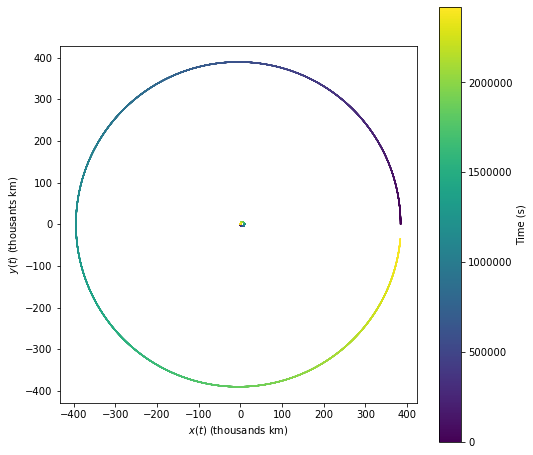

In [6]:
%%time
def F_EarthOnMoon(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t):
    # Helper function, to compute the forces

    x, y, z = xM - xE, yM - yE, zM - zE
    r = np.sqrt(x**2 + y**2 + z**2)
    f = - G*Me*Mm / r**2
    return f * x/r, f * y/r, f * z/r

def twobody(t, y):
    # Unpack the input vector: it's easier to correctly implement the
    # necessary equations if we have descriptive names
    (xM, yM, zM, xE, yE, zE, vxM, vyM, vzM, vxE, vyE, vzE) = y

    # compute the Earth-Moon force, once.
    fx, fy, fz = F_EarthOnMoon(xM, yM, zM, vxM, vyM, vzM, xE, yE, zE, vxE, vyE, vzE, t)

    # compute and return df/dt, each entry corresponding to one of 
    # the 12 differential equations' f_i, and return it as an array
    # because this is what our new `integrate` function expects.
    ret = np.asarray([
        vxM, vyM, vzM, vxE, vyE, vzE, # various xdot functions
        fx/Mm,  fy/Mm,  fz/Mm, -fx/Me, -fy/Me, -fz/Me, # various vdot functions
    ])
    return ret

G = 6.67e-11 # in N kg^-2 m^2
Me = 5.972e24 # mass of the Earth
Mm = 7.34767209e22 # mass of the Moon
rMoon = 384_400_000  # Earth-Moon distance
vCircM = np.sqrt(G*(Me+Mm)/rMoon)  # Circular speed of the Moon (explanation further down)
vCircE = vCircM*Mm/Me # Circular speed of the Earth (explanation further down)

km = 1000 # meters in a kilometer
day = 60*60*24 # seconds in a day

tbegin, tend = 0, 28*day
xM0, vxM0 = rMoon, 0
yM0, vyM0 = 0, vCircM
zM0, vzM0 = 0, 0

xE0, vxE0 = 0, 0
yE0, vyE0 = 0, -vCircE
zE0, vzE0 = 0, 0

dt = 0.001*day

# Pack everything into a single vector as this is what our universal `integrate`
# function expects
y0 = [xM0, yM0, zM0, xE0, yE0, zE0, vxM0, vyM0, vzM0, vxE0, vyE0, vzE0]

# run integration
tval, yout = integrate(twobody, (tbegin, tend), y0, dt)

# unpack the result (as this makes it easier to understand and plot)
xMval, yMval, zMval, xEval, yEval, zEval, vxMval, vyMval, vzMval, vxEval, vyEval, vzEval = yout

fig = plt.figure(figsize=(8, 8))
plt.scatter(xMval / (1000*km), yMval / (1000*km), c=tval, s=0.1)
plt.scatter(xEval / (1000*km), yEval / (1000*km), c=tval, s=0.1)
plt.gca().set_aspect('equal')
plt.xlabel("$x(t)$ (thousands km)")
plt.ylabel("$y(t)$ (thousants km)")
plt.colorbar(label="Time (s)");

And that's it!

This new implementation for the two-body problem is more compact, readable and faster. And it re-uses the new `integrate` function.

**Exercise:** to make sure you understand how all this works, re-implement the ballistic projectile example in this new framework, using the univeral `integrate` function.

## High-quality Library Solvers 

There was an ulterior motive behind our design of the inputs and outputs to the `integrate` function (also known as the Application Programming Interface -- the API): (nearly) the same inputs/outputs are used by a high-quality ODE solver provided by the SciPy library named:

`scipy.integrate.solve_ivp`

With no changes to our code (the `twobody` function), we can now use this better solver to integrate our two-body problem:

CPU times: user 249 ms, sys: 50.2 ms, total: 299 ms
Wall time: 362 ms


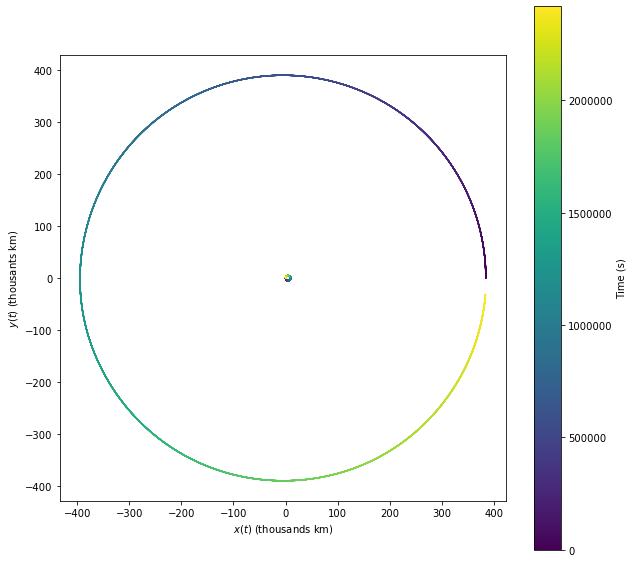

In [7]:
%%time
from scipy.integrate import solve_ivp

# `solve_ivp` doesn't take the `dt` argument; it takes
# the times at which to evaluate the variables.
teval = np.arange(tbegin, tend, dt)

# this is the function call!
sol = solve_ivp(twobody, (tbegin, tend), y0, t_eval=teval, method='DOP853')

# the results are returned in a "bunch" object, so we unpack it slightly differently
tval = sol.t
xMval, yMval, zMval, xEval, yEval, zEval, vxMval, vyMval, vzMval, vxEval, vyEval, vzEval = sol.y

# plotting remains the same
fig = plt.figure(figsize=(10, 10))
plt.scatter(xMval / (1000*km), yMval / (1000*km), c=tval, s=0.1)
plt.scatter(xEval / (1000*km), yEval / (1000*km), c=tval, s=0.1)
plt.gca().set_aspect('equal')
plt.xlabel("$x(t)$ (thousands km)")
plt.ylabel("$y(t)$ (thousants km)")
plt.colorbar(label="Time (s)");

The main advantage to using a high-quality solver provided by a well-known library is that it will implement one or more fast ODE-solving methods, and generally be (much) more accurate than our simple Euler.

Going forward we'll rely more and more on library-provided solvers. In the end, we may even use special-purpose integrators built for Solar System and and/or N-body gravitational problems (such as Rebound).

Still, our custom implementations were *irreplacable* in the process of learning how numerical integration works (and also to know where to begin should you try to invent/implement a new integration technique yourself!)

**Exercises:**
1. Compare the accuracy of solutions given by `solve_ivp` and the `integrate` method vs. the analytic results for a body on a spring. Which one is more accurate?
1. Make sure the ballistic projectile example workes with the `solve_ivp` function.

## The Big Challenge: The N-body Problem

We're finally ready to tackle the N-body problem: computing the positions $r_i$ as a function of time $t$ of $N$ bodies of masses $M_i$, mutually interacting with the forces of gravity.

The ODE system for the N-body problem is as follows:

$$ \dot{\vec{r}}_i = \vec{v}_i $$
$$ \dot{\vec{v}}_i = \sum_{i \neq j} - \frac{G M_j}{|\vec{r}_j - \vec{r}_i|^3} \left(\vec{r}_j - \vec{r}_i\right) $$

The equation for $\dot{\vec{v}}_i$ sums up the accelerations on body $i$ due to the forces exerted by all _other_ bodies $j$ (that is what the notation $i \neq j$ is meant to imply). Also note that each of these equations are actually *three* equations -- one for $x, y, z$, each. I.e., if there were 4 bodies, we'd have $4\cdot2\cdot3 = 24$ equations.

**Your homework is to implement a general-purpose N-body integration function**. This function must look as follows:

```python
def nbody(t, y):
    ... your implementation goes here ...
```

The `y` array is similar to the `y` array of the `twobody` function -- a list of cartesian components of position, followed by components of velocities; i.e. `(x1, y1, z1, x2, y2, z2 ... xN, yN, zN, vx1, vy1, vz1, ... vxN, vyN, vzN)`. It must return the derivatives, similar to how `twobody` did it. But, importantly, it should not be limited to a specific number of bodies; it should figure out the number of bodies being integrated from the length of the $y$ array -- e.g., if `y = 24`, then it should know there are `N=24 // 6 = 4` bodies.

Finally, you will need the masses for these bodies. Assume there's an externally defined array $M$, that holds these. Note that Python indexes arrays starting with zero, so the mass of the first body will be in `M[0]`, the mass of the second in `M[1]`, etc.

You can write your solution here:

In [ ]:
def nbody(t, y):
    ... your implementation goes here ...


As you write your function, test it with these following two pieces of code. The first one (below) should reproduce exactly the same result as the `twobody` function:

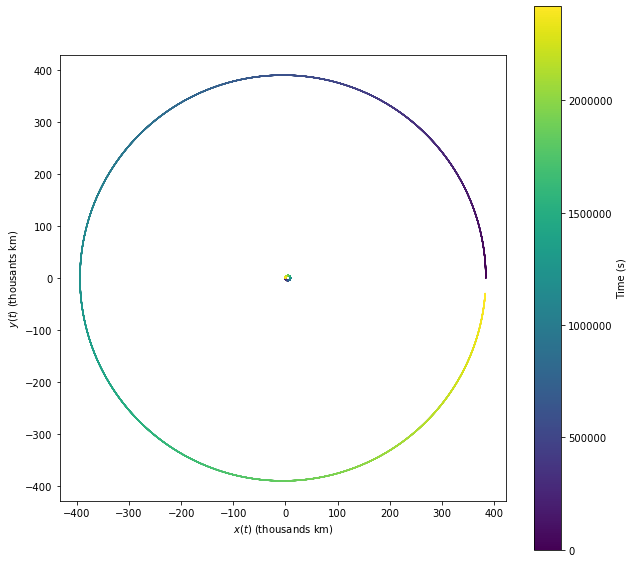

In [9]:
G = 6.67e-11 # in N kg^-2 m^2
Me = 5.972e24 # mass of the Earth
Mm = 7.34767209e22 # mass of the Moon
rMoon = 384_400_000  # Earth-Moon distance
vCircM = np.sqrt(G*(Me+Mm)/rMoon)  # Circular speed of the Moon (explanation further down)
vCircE = vCircM*Mm/Me # Circular speed of the Earth (explanation further down)

km = 1000 # meters in a kilometer
day = 60*60*24 # seconds in a day

tbegin, tend = 0, 28*day
xM0, vxM0 = rMoon, 0
yM0, vyM0 = 0, vCircM
zM0, vzM0 = 0, 0

xE0, vxE0 = 0, 0
yE0, vyE0 = 0, -vCircE
zE0, vzE0 = 0, 0

dt = 0.001*day

y0 = [xM0, yM0, zM0, xE0, yE0, zE0, vxM0, vyM0, vzM0, vxE0, vyE0, vzE0]
M = [Mm, Me]

teval = np.arange(tbegin, tend, dt)

sol = solve_ivp(nbody, (tbegin, tend), y0, t_eval=teval, method='RK45', rtol=1e-5)
tval = sol.t
xMval, yMval, zMval, xEval, yEval, zEval, vxMval, vyMval, vzMval, vxEval, vyEval, vzEval = sol.y

fig = plt.figure(figsize=(10, 10))
plt.scatter(xMval / (1000*km), yMval / (1000*km), c=tval, s=0.1)
plt.scatter(xEval / (1000*km), yEval / (1000*km), c=tval, s=0.1)
plt.gca().set_aspect('equal')
plt.xlabel("$x(t)$ (thousands km)")
plt.ylabel("$y(t)$ (thousants km)")
plt.colorbar(label="Time (s)");

Note: I've included the plot you should get if your code is correct.

And for the second one, we'll launch a projectile to the Moon. The initial conditions below set up a situation where a projectile is launched (horizontally, to make things interesting) from the surface of the Earth and which intercepts the Moon after about ~15 days of travel.

If your solution is correct, the code below should run **with exactly the same `nbody` function** as the code above.

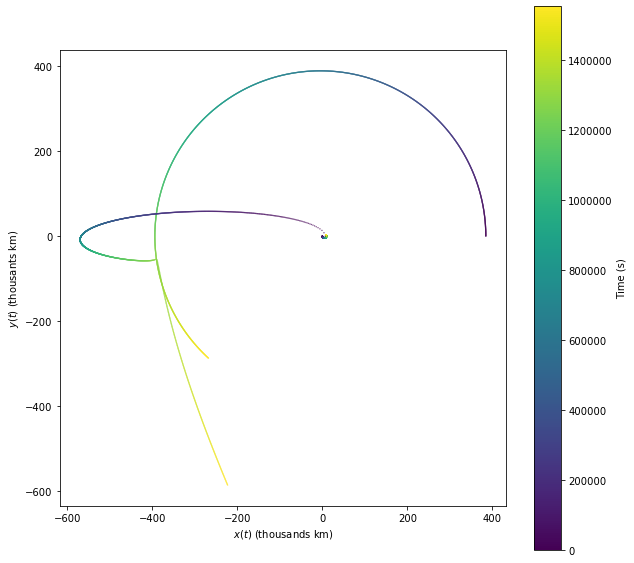

In [10]:
G = 6.67e-11 # in N kg^-2 m^2
Me = 5.972e24 # mass of the Earth
Mm = 7.34767209e22 # mass of the Moon
Ms = 100_000 # mass of a spacecraft
Re = 6_371_000 # radius of the Earth
rMoon = 384_400_000  # Earth-Moon distance
vCircM = np.sqrt(G*(Me+Mm)/rMoon)  # Circular speed of the Moon (explanation further down)
vCircE = vCircM*Mm/Me # Circular speed of the Earth (explanation further down)

km = 1000 # meters in a kilometer
day = 60*60*24 # seconds in a day

tbegin, tend = 0, 18*day
xM0, vxM0 = rMoon, 0
yM0, vyM0 = 0, vCircM
zM0, vzM0 = 0, 0

xE0, vxE0 = 0, 0
yE0, vyE0 = 0, -vCircE
zE0, vzE0 = 0, 0

xS0, vxS0 = Re, 0
yS0, vyS0 = 0, 11_108
zS0, vzS0 = 0, 0

dt = 0.01*day

y0 = [xM0, yM0, zM0, xE0, yE0, zE0, xS0, yS0, zS0,
      vxM0, vyM0, vzM0, vxE0, vyE0, vzE0, vxS0, vyS0, vzS0]
M = [Mm, Me, Ms]

teval = np.arange(tbegin, tend, dt)

sol = solve_ivp(nbody, (tbegin, tend), y0, t_eval=teval, method='DOP853', rtol=1e-6)
tval = sol.t
xMval, yMval, zMval, xEval, yEval, zEval, xSval, ySval, zSval = sol.y[:9]

fig = plt.figure(figsize=(10, 10))
plt.scatter(xMval / (1000*km), yMval / (1000*km), c=tval, s=0.1)
plt.scatter(xEval / (1000*km), yEval / (1000*km), c=tval, s=0.1)
plt.scatter(xSval / (1000*km), ySval / (1000*km), c=tval, s=0.1)
plt.gca().set_aspect('equal')
plt.xlabel("$x(t)$ (thousands km)")
plt.ylabel("$y(t)$ (thousants km)")
plt.colorbar(label="Time (s)");

And, for fun, you'll also be able to plot the distance to the Moon vs. time:

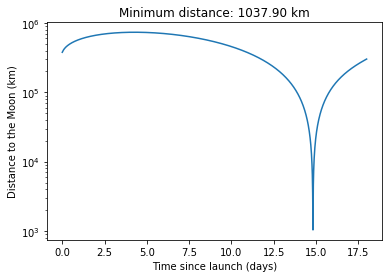

In [11]:
# distance to the Moon vs. time
moonDist = np.sqrt((xMval - xSval)**2 + (yMval - ySval)**2 + (zMval - zSval)**2)
plt.plot(tval / day, moonDist / km)
plt.gca().set_yscale('log')
plt.xlabel("Time since launch (days)")
plt.ylabel("Distance to the Moon (km)")
plt.title(f"Minimum distance: {min(moonDist / km):.2f} km");